100%|██████████| 4/4 [00:48<00:00, 12.06s/it]


array sizes: [1880060, 2202746, 912330, 1266944]
max error: [31.816679718873274, 9.02198988533712, 19.951403244930972, 32.84759370596845]
q99 error: [1.2770539557891421e-05, 1.3027110639995954e-05, 1.3528911040339153e-05, 1.1831363241867619e-05]


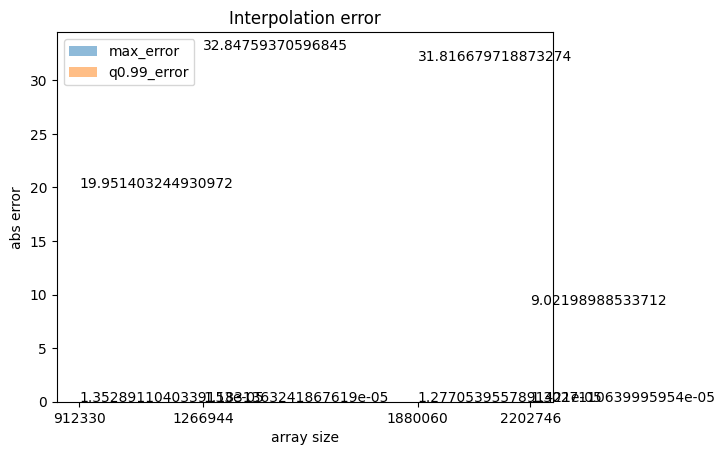

In [1]:
from parinterp import Linear2DInterpolator
from scipy.interpolate import griddata
import numpy as np
from typing import Mapping
from deli import load_json
from timeit import timeit
from tqdm import tqdm
from matplotlib import pyplot as plt


path = load_json('path.json')

arrays: Mapping[str, np.ndarray]= dict()

for key, p in path.items():
    arrays[key] = np.load(p, allow_pickle=True)

sizes = []
times = {'parinterp': [], 'scipy': []}
max_error = []
q = 0.99
q_error = []
for k, x in tqdm(arrays.items()):
    add_cols = x.shape[1] // 4
    distances = np.concatenate((x[...,-add_cols:], x, x[...,:add_cols] ), axis=1)
    int_points = np.transpose((np.isnan(distances)).nonzero())
    x_points: np.ndarray = np.transpose((~np.isnan(distances)).nonzero())
    x_values = distances[~np.isnan(distances)]
    surface_map = distances.copy()

    my_interp = lambda: Linear2DInterpolator(x_points, -1)(int_points, x_values, 0.0)
    sp_interp = lambda: griddata(x_points, x_values, int_points, method='linear', fill_value=0.0)

    sizes.append(x_points.size + int_points.size)

    # times['parinterp'].append(timeit(my_interp, number=4) / 4)
    # times['scipy'].append(timeit(sp_interp, number=4) / 4)

    my_interp = my_interp()
    sp_interp = sp_interp()

    ae = np.abs(my_interp - sp_interp)
    max_error.append(ae.max())
    q_error.append(np.quantile(ae, q))

print('array sizes:', sizes)
print('max error:', max_error)
print('q99 error:', q_error)
plt.bar(sizes, max_error, label='max_error', alpha=0.5)
plt.bar(sizes, q_error, label=f'q{q}_error', alpha=0.5)
plt.xticks(sizes, sizes)
errors = max_error + q_error
sizes = sizes + sizes
for i in range(len(sizes)):
    plt.text(x=sizes[i] , y=errors[i], s=errors[i], size=10)
plt.legend()
plt.title('Interpolation error')
plt.xlabel('array size')
plt.ylabel('abs error')
plt.savefig('interpolation_error.jpg')
plt.show()
# plt.clf()
